In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Loading data


In [2]:
data = pd.read_csv("Data Analysis Task.csv")
data.head()

c:\Users\Omkar\anaconda3\envs\RL\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date,ordering_channel,mode_of_payment,bag_id,shipment_id,affiliate_bag_id,order_id,Itemcode,sku_code,ean,...,Store_City,Store_State,del_cust_name,del_cust_mobile,l1_category,l3_category,Company_Name,hsn_code,invoice_id,MRP
0,2021-04-24 22:49:19 UTC,MARKETPLACE,FY_FLIPKART_ASSURED,10299882,1.619420e+19,dbd766d8-dfe2-49d6-8dea-3808c2ff1998,FYMP6084531601CC91EE,S9C5089-040,8.90718E+12,NaN,...,DEHRADUN,UTTARAKHAND,Saquib Younus,9748408797,"[""Footwear""]",Flip Flops,SSIPL LIFESTYLE PRIVATE LIMITED,64041190,NaN,849.0
1,2021-08-11 20:43:46 UTC,ECOMM,ECOMM,11609617,1.629200e+19,11609617,FY6113E92A014E6066CA,927389-036,8.8655E+11,NaN,...,MATHURA,UTTAR PRADESH,Rahul Tamaskar,9685761206,"[""Clothing""]",Activewear Joggers,SSIPL LIFESTYLE PRIVATE LIMITED,61034300,SS030/00535,2195.0
2,2021-03-09 17:31:07 UTC,MARKETPLACE,FY_FLIPKART_ASSURED,9907918,1.615290e+19,842acd6b-f3ac-4662-b92d-31d177b25b05,FYMP604763820183E9EF,S1810401-010,8.90718E+12,NaN,...,PUNE,MAHARASHTRA,Gaurav Kumar,8700697973,"[""Clothing""]",Activewear Joggers,SSIPL LIFESTYLE PRIVATE LIMITED,61103010,T0090/12371,1199.0
3,2021-09-29 22:57:12 UTC,MARKETPLACE,FY_FLIPKART_ASSURED,12331936,1.632940e+19,1bde7407-e1b1-41ba-9f90-bb9c1feec7ed,FYMP6154A1F00169BE96,AV5014-010,8.90718E+12,NaN,...,NEW DELHI,DELHI,Sandip Jena,9348036053,"[""Footwear""]",Sneakers,SSIPL LIFESTYLE PRIVATE LIMITED,64041190,NaN,1999.0
4,2021-09-29 15:30:17 UTC,MARKETPLACE,FY_AMAZON,12326311,1.632910e+19,12326311,FYMP6154393001A8F48D,FJ9217,4.06051E+12,NaN,...,MATHURA,UTTAR PRADESH,Amazon default customer,234242340,"[""Clothing""]",T-Shirts,SSIPL LIFESTYLE PRIVATE LIMITED,61099090,ss030/00906,999.0


In [3]:
data.columns

Index(['date', 'ordering_channel', 'mode_of_payment', 'bag_id', 'shipment_id',
       'affiliate_bag_id', 'order_id', 'Itemcode', 'sku_code', 'ean', 'upc',
       'item_gender', 'article_qnty', 'ProdName', 'Size', 'Brand', 'Gender',
       'payment_mode', 'ESP', 'Amount_Paid', 'unit_price', 'Cur_Status',
       'Address_1', 'Pincode', 'Delivery_State', 'Location',
       'Marketplace_awb_number', 'Cust_Name', 'Mobile', 'Store_Code',
       'Cur_Store_Code', 'Store_Address', 'Store_City', 'Store_State',
       'del_cust_name', 'del_cust_mobile', 'l1_category', 'l3_category',
       'Company_Name', 'hsn_code', 'invoice_id', 'MRP'],
      dtype='object')

# Data analysis

### Feature analysis

In [4]:
# Dropping unwanted features
drop_columns=["date","bag_id", "shipment_id","affiliate_bag_id","order_id","sku_code", "ean", "upc", "Gender","Address_1", "Marketplace_awb_number","Cust_Name",
              "Mobile", "Store_Code", "Cur_Store_Code", "Store_Address","del_cust_name", "del_cust_mobile", "Company_Name", "hsn_code","invoice_id", "Location",
              "Pincode", "Store_City", "Itemcode" ]
if any(column in drop_columns for column in data.columns.to_list()):
    data.drop(columns=drop_columns, inplace=True)

print(data.columns)
print()
print("Number of variables: {}".format( data.columns.nunique()))


Index(['ordering_channel', 'mode_of_payment', 'item_gender', 'article_qnty',
       'ProdName', 'Size', 'Brand', 'payment_mode', 'ESP', 'Amount_Paid',
       'unit_price', 'Cur_Status', 'Delivery_State', 'Store_State',
       'l1_category', 'l3_category', 'MRP'],
      dtype='object')

Number of variables: 17


In [5]:
#Checking if Cur_Status is usable categorical variable
data["Cur_Status"].value_counts().sort_values(ascending=False) #.plot.bar(figsize=(16,10))

Handed Over to DG                 13946
Delivery Done                     12318
Cancelled by Fynd                  5464
Return Accepted                    5039
Cancelled by Customer              4130
RTO Bag Accepted                   1263
Return Request Cancelled            675
Bag Packed                          585
Refund Completed                    436
Delivery Done to store              402
In Transit                          315
RTO Bag Delivered to Store          266
Return Bag In Transit               226
RTO In Transit                      127
Return Bag Not Picked                78
Bag Lost in transit                  67
Bag Lost in Transit                  48
Placed                               44
DP Assigned                          29
Out For Delivery                     26
Bag Not Picked                       20
Out for Delivery to Store            16
Delivery Attempt Made                14
Return Bag Picked                    14
Return Request Cancelled by DP       12


In [6]:
# Making a copy of data and dropping some features to analyse them later separately
data2 = data.copy()
if ["Cur_Status", "mode_of_payment"] in data.columns.tolist():
   data.drop(columns=["Cur_Status", "mode_of_payment"], inplace =True)

In [7]:
data.nunique()

ordering_channel       3
mode_of_payment        6
item_gender            3
article_qnty         214
ProdName            2155
Size                  76
Brand                 11
payment_mode           8
ESP                  738
Amount_Paid         1083
unit_price           787
Cur_Status            33
Delivery_State        64
Store_State           21
l1_category            9
l3_category           52
MRP                  333
dtype: int64

### Separating categorical and numeric variables

In [8]:
vars = data.columns.to_list()
cat_vars = [var for var in vars if data[var].dtype == 'O']
cat_vars

['ordering_channel',
 'mode_of_payment',
 'item_gender',
 'ProdName',
 'Size',
 'Brand',
 'payment_mode',
 'Cur_Status',
 'Delivery_State',
 'Store_State',
 'l1_category',
 'l3_category']

In [9]:
num_vars = [var for var in vars if var not in cat_vars]
num_vars

['article_qnty', 'ESP', 'Amount_Paid', 'unit_price', 'MRP']

### Feature data analysis

#### A. Numerical variables

In [10]:
data[num_vars].isnull().mean()

article_qnty    0.0
ESP             0.0
Amount_Paid     0.0
unit_price      0.0
MRP             0.0
dtype: float64

In [11]:
0 in data[num_vars].values

True

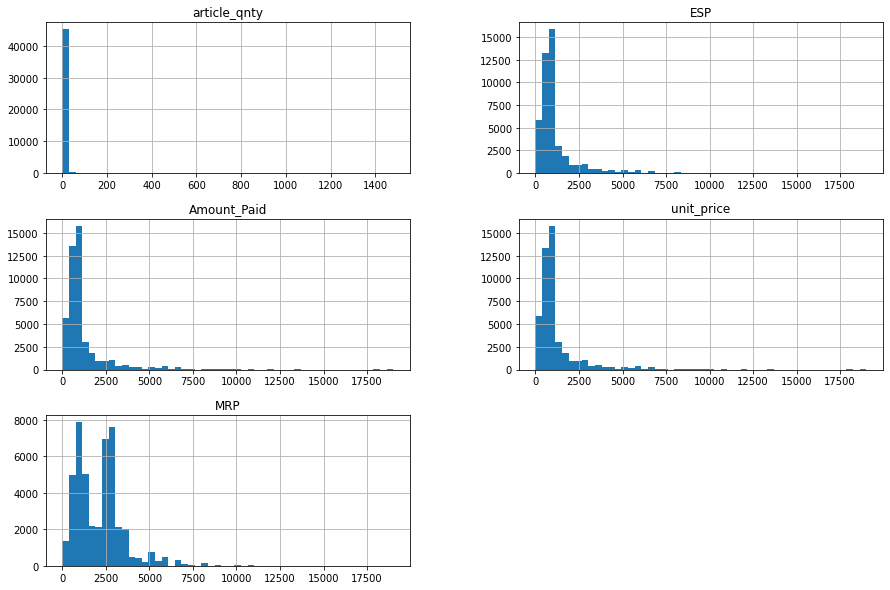

In [12]:
data[num_vars].hist(figsize=(15,10),bins=50)
plt.show()

array([[<AxesSubplot:title={'center':'article_qnty'}>,
        <AxesSubplot:title={'center':'ESP'}>],
       [<AxesSubplot:title={'center':'Amount_Paid'}>,
        <AxesSubplot:title={'center':'unit_price'}>],
       [<AxesSubplot:title={'center':'MRP'}>, <AxesSubplot:>]],
      dtype=object)

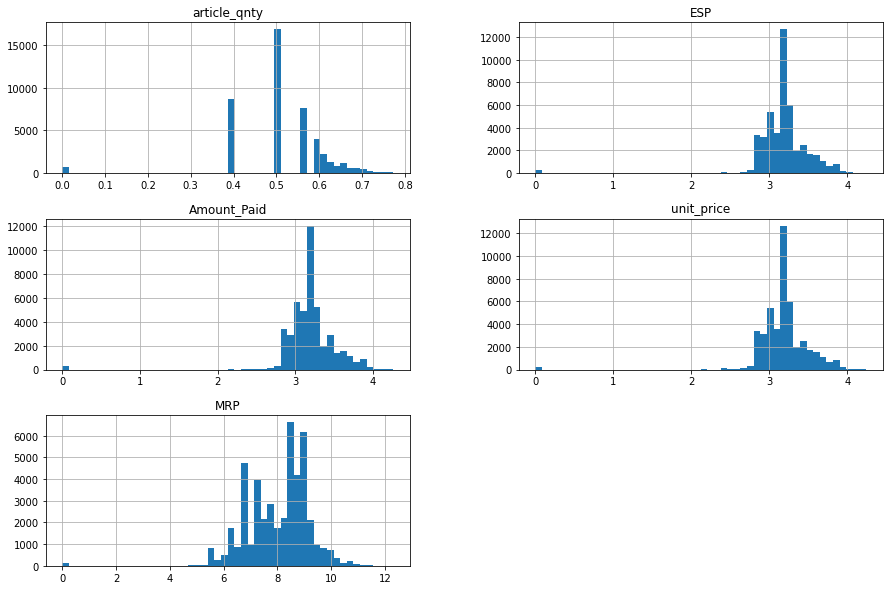

In [13]:
# Trying feature engineering for later analysis
df = data.copy()
for var in ["ESP","Amount_Paid", "unit_price", "MRP", "article_qnty"]:
    df[var], param = stats.yeojohnson(df[var])
    df[var]= stats.yeojohnson(df[var], lmbda = param)
    
df[num_vars].hist(bins = 50, figsize=(15,10))


### B. Categorical Variables

In [14]:
#checking for null values
data.dropna(subset = ["Delivery_State"], inplace= True)
data[cat_vars].isnull().mean()


ordering_channel    0.000000
mode_of_payment     0.000000
item_gender         0.218207
ProdName            0.000000
Size                0.023312
Brand               0.000000
payment_mode        0.000000
Cur_Status          0.000000
Delivery_State      0.000000
Store_State         0.000000
l1_category         0.000000
l3_category         0.000000
dtype: float64

In [15]:
data[cat_vars].any().isnull()

ordering_channel    False
mode_of_payment     False
item_gender         False
ProdName            False
Size                False
Brand               False
payment_mode        False
Cur_Status          False
Delivery_State      False
Store_State         False
l1_category         False
l3_category         False
dtype: bool

In [16]:
#Checking item gender values
data["item_gender"].unique()

array(['Men', nan, 'Women', 'Boys'], dtype=object)

In [17]:
# Replacing NaN values in item gender 
for i, value in enumerate(data["item_gender"].values):
    if(pd.isna(value)):
        prodName = data.iloc[i, data.columns.get_loc("ProdName")].lower()
        if "men" in prodName:
            data.iloc[i, data.columns.get_loc("item_gender")] = "Men"
        elif "women" in prodName:
            data.iloc[i, data.columns.get_loc("item_gender")] = "Women"
        elif "kids" in prodName:
            data.iloc[i, data.columns.get_loc("item_gender")] = "Boys"
        else:
            data.iloc[i, data.columns.get_loc("item_gender")] = "Unisex"
            
data["item_gender"].unique()  

array(['Men', 'Unisex', 'Women', 'Boys'], dtype=object)

In [18]:
# Data analysis for Size
data["Size"].unique()

array([nan, 'L', 'M', '11', '6', '7', 'XL', '5', 'OS', '9', '10', '37/40',
       '8', 'S', '13', '39-42', '37-40', 'XXL', '4', 'L-173XW-51', '3',
       '75CM', '12', '182X60CM', '6.5', '8.5', '24OZ', 'L/XL', 'FREE',
       'L-182XW-60CM', 'OSFM', '7.5', '3XL', '2XL', '152', '43-46', '2',
       '16OZ', '6Y', 'L-30XW-20X', 'L-33XW-17X', 'ADULT', '22OZ',
       'L-32XW-25X', 'L-173 CM X W- 51 CM', '140', '12Y', '164', '80C',
       '2XL7', '35-38', '10.5', '40', 'NS', 'X', '39/42', '9.5', 'MISC',
       '35/38', '8Y', '1', '10Y', '-12', '3538', '128', '40-42', '5.5',
       'L-22CM', '4Y', 'UNISEX', '4.5', 'ONE SIZE', 'K', '18OZ', '5Y',
       '3134', '110'], dtype=object)

In [19]:
# median_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data["Size"] = data["Size"].astype('O')
median_imputer = CategoricalImputer(imputation_method='frequent', variables= ["Size", "l1_category"])
data= median_imputer.fit_transform(data)
median_imputer.imputer_dict_

{'Size': '9', 'l1_category': '["Footwear"]'}

In [20]:
for i, size in enumerate(data["Size"]):
    if size[0] == 'L':
        data.iloc[i, data.columns.get_loc("Size")] = 'L'
    elif size[:3] == '2XL':
        data.iloc[i, data.columns.get_loc("Size")] = 'XXL'
    elif size[:3] == '3XL':
        data.iloc[i, data.columns.get_loc("Size")] = 'XXXL'

In [21]:
data["Size"].unique()

array(['9', 'L', 'M', '11', '6', '7', 'XL', '5', 'OS', '10', '37/40', '8',
       'S', '13', '39-42', '37-40', 'XXL', '4', '3', '75CM', '12',
       '182X60CM', '6.5', '8.5', '24OZ', 'FREE', 'OSFM', '7.5', 'XXXL',
       '152', '43-46', '2', '16OZ', '6Y', 'ADULT', '22OZ', '140', '12Y',
       '164', '80C', '35-38', '10.5', '40', 'NS', 'X', '39/42', '9.5',
       'MISC', '35/38', '8Y', '1', '10Y', '-12', '3538', '128', '40-42',
       '5.5', '4Y', 'UNISEX', '4.5', 'ONE SIZE', 'K', '18OZ', '5Y',
       '3134', '110'], dtype=object)

In [22]:
if "ProdName" in data.columns:
    data.drop(columns=["ProdName"])

In [23]:
discrete_vars = [var for var in cat_vars if data[var].nunique() < 20]
discrete_vars

['ordering_channel',
 'mode_of_payment',
 'item_gender',
 'Brand',
 'payment_mode',
 'l1_category']

In [24]:
data[discrete_vars].nunique().sort_values(ascending=False)

Brand               11
l1_category          9
payment_mode         8
mode_of_payment      6
item_gender          4
ordering_channel     3
dtype: int64

In [25]:
data["l1_category"].unique()

array(['["Footwear"]', '["Clothing"]', '["Accessories"]',
       '["Footwear", "Footwear"]', '["Others"]', '["Personal Care"]',
       '["Footwear", "Footwear", "Footwear"]', '["Clothing", "Clothing"]',
       '["Innerwear & Nightwear"]'], dtype=object)

In [26]:
data.loc[data.l1_category.str.contains("Footwear"), 'l1_category'] = "Footwear"
data.loc[data.l1_category.str.contains("Clothing"), 'l1_category'] = "Clothing"

In [27]:
for var in discrete_vars:
    print("Unique values in {} : {}".format(var, data[var].unique()))
    

Unique values in ordering_channel : ['MARKETPLACE' 'ECOMM' 'AFFILIATE']
Unique values in mode_of_payment : ['FY_FLIPKART_ASSURED' 'ECOMM' 'FY_AMAZON' 'FY_MYNTRA' 'FY_TATACLIQ'
 'FYND']
Unique values in item_gender : ['Men' 'Unisex' 'Women' 'Boys']
Unique values in Brand : ['Lotto' 'Nike' 'adidas' 'Puma' 'Reebok' 'Skechers' 'Asics' 'ALCIS'
 'Dcyphr' 'U.S. Polo Assn.' 'WILDCRAFT']
Unique values in payment_mode : ['PartnerPay' 'COD' 'Cash on Delivery' 'CARD' 'UPI' 'NB' 'WL' 'PL']
Unique values in l1_category : ['Footwear' 'Clothing' '["Accessories"]' '["Others"]' '["Personal Care"]'
 '["Innerwear & Nightwear"]']


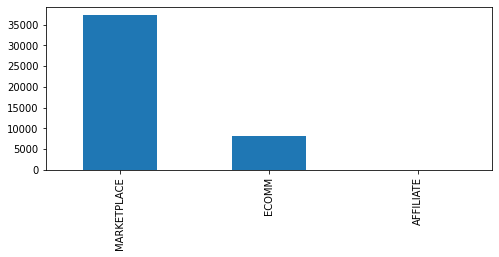

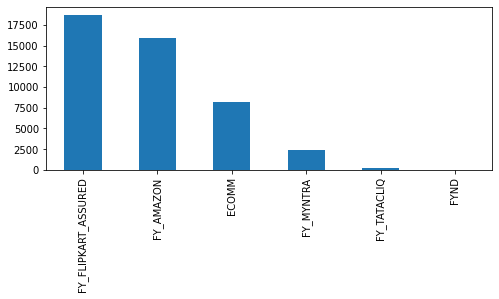

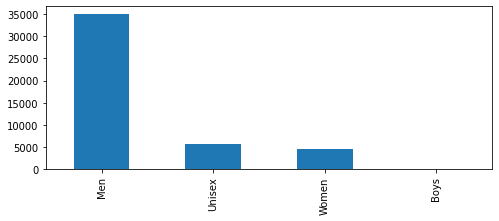

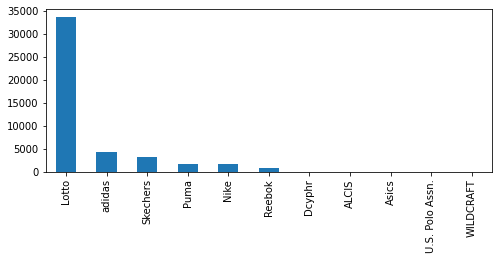

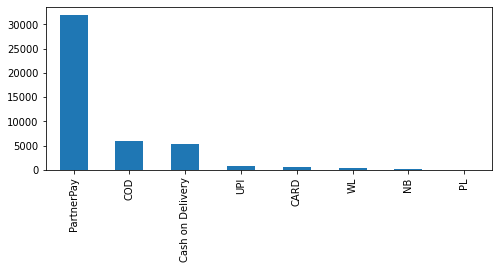

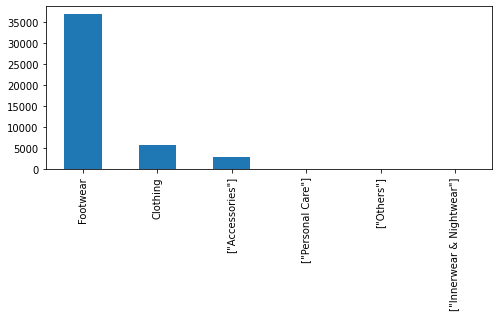

In [28]:
for var in discrete_vars:
    data[var].value_counts().sort_values(ascending=False).plot.bar(figsize=(8,3))
    plt.show()

In [29]:
categorical_variables = [var for var in cat_vars if var not in discrete_vars]
categorical_variables.remove("ProdName")
categorical_variables.remove("Cur_Status")
categorical_variables

['Size', 'Delivery_State', 'Store_State', 'l3_category']

In [30]:
group_by_cat_vars = ["Brand", "l3_category", "Delivery_State","Store_State", "Size", "payment_mode", "item_gender", "MRP", "article_qnty"]

In [33]:
[var for var in group_by_cat_vars if var not in num_vars]

['Brand',
 'l3_category',
 'Delivery_State',
 'Store_State',
 'Size',
 'payment_mode',
 'item_gender']

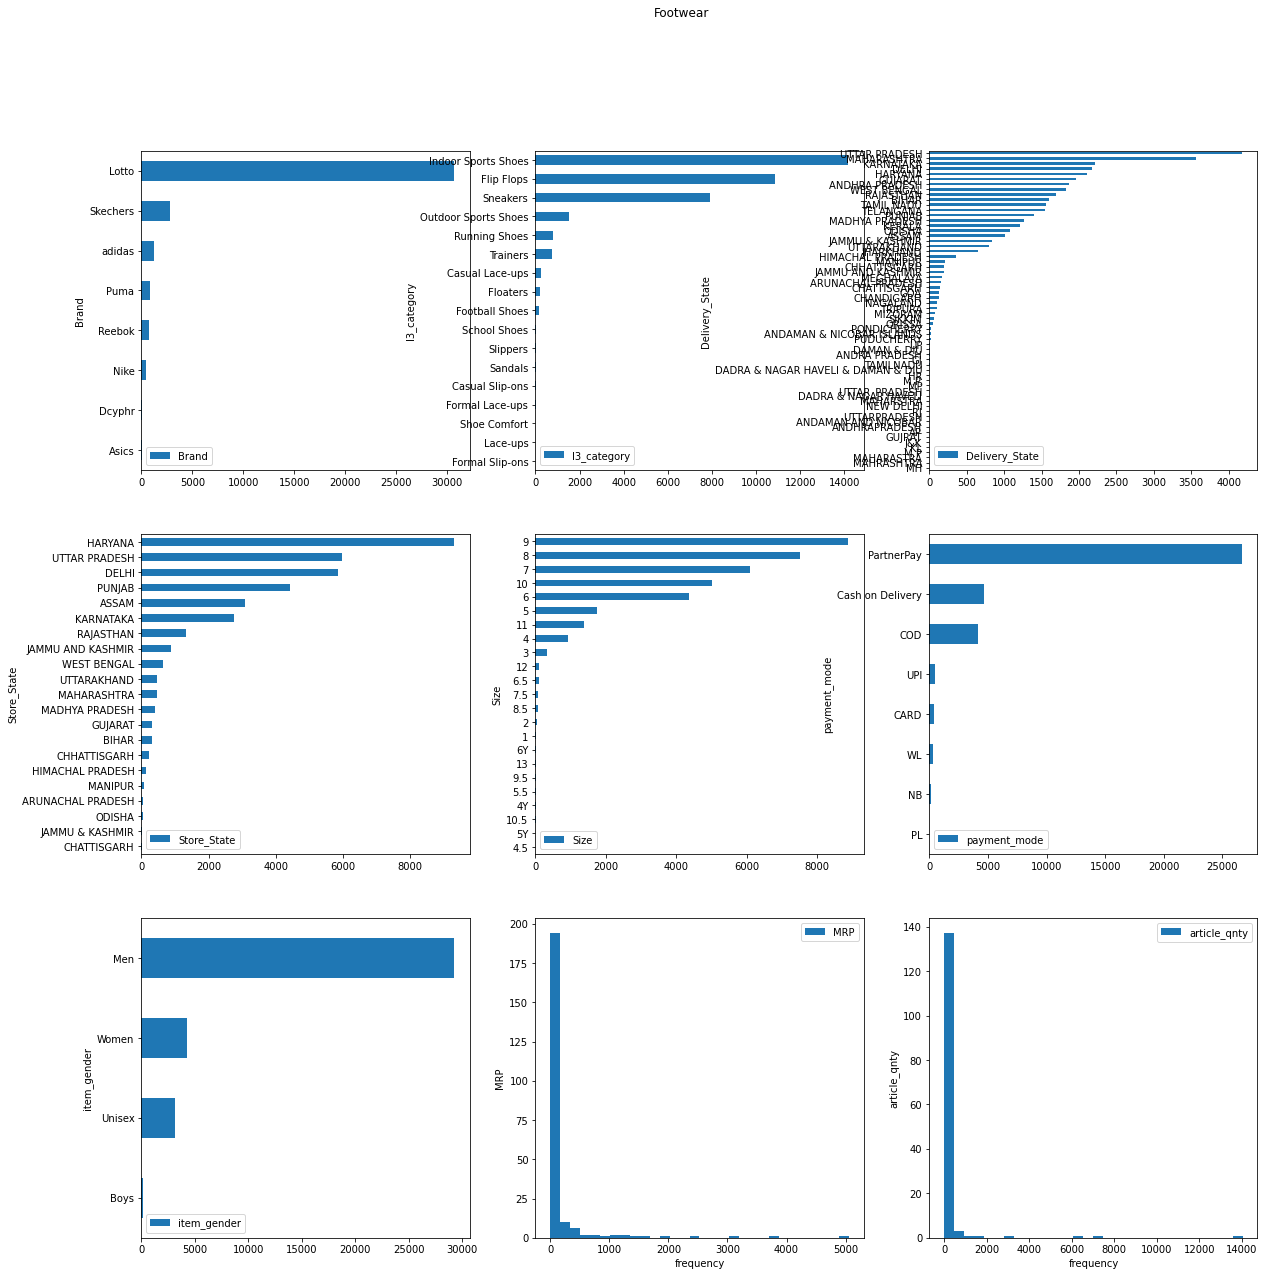

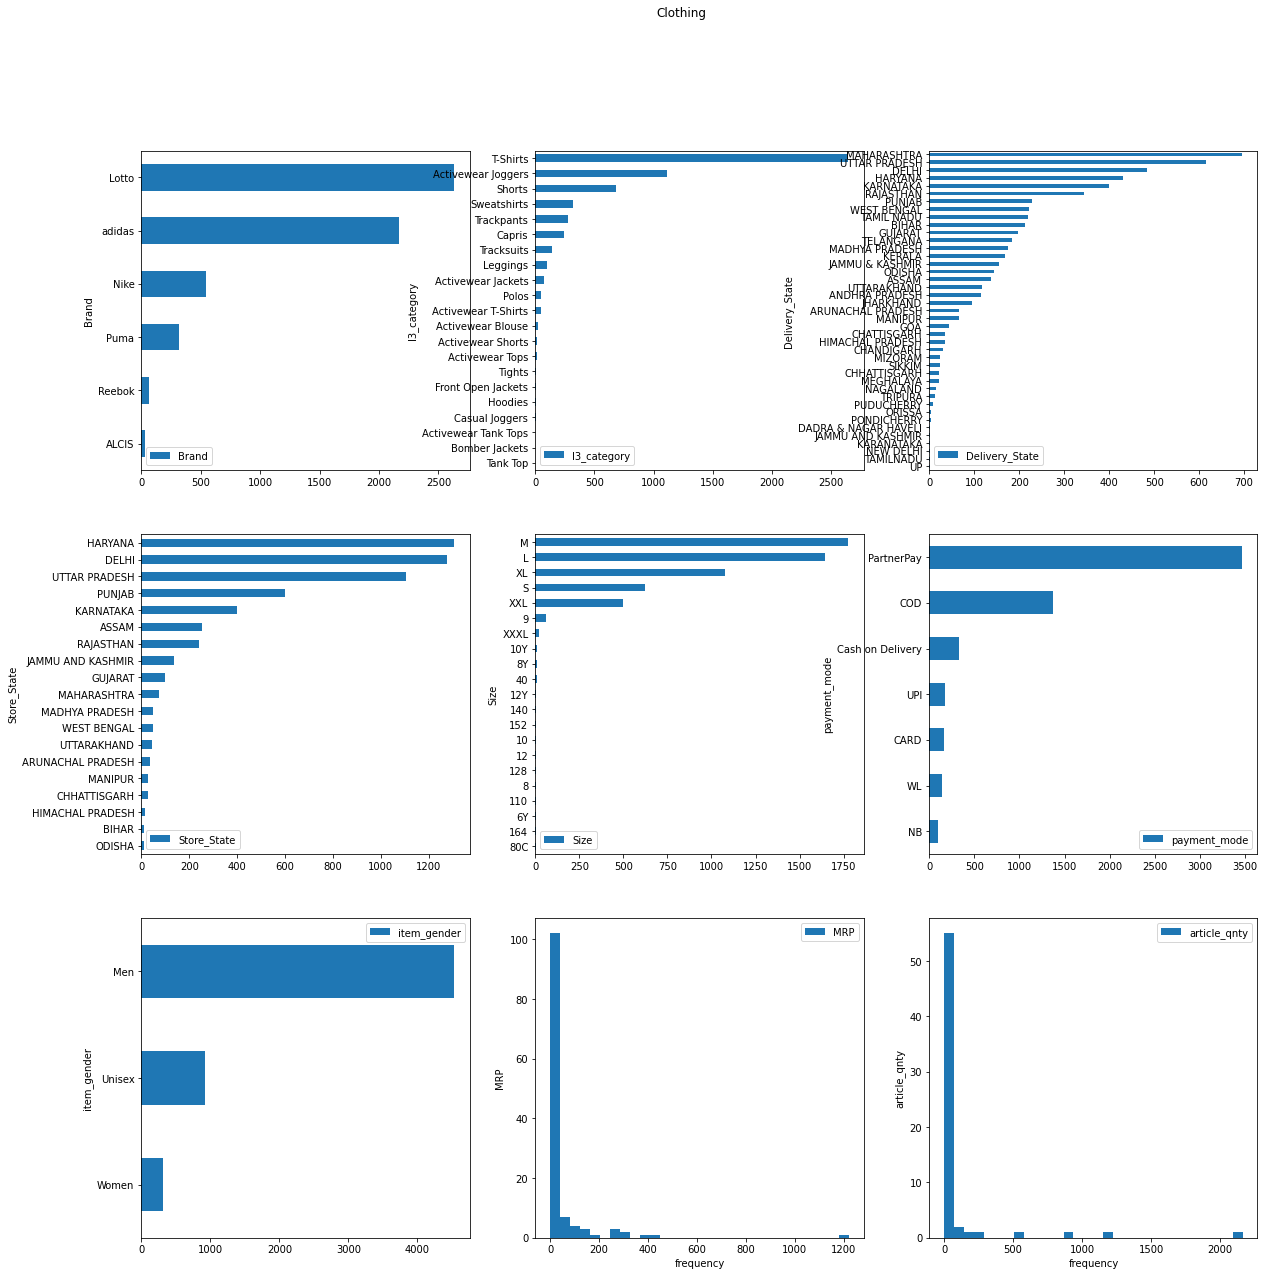

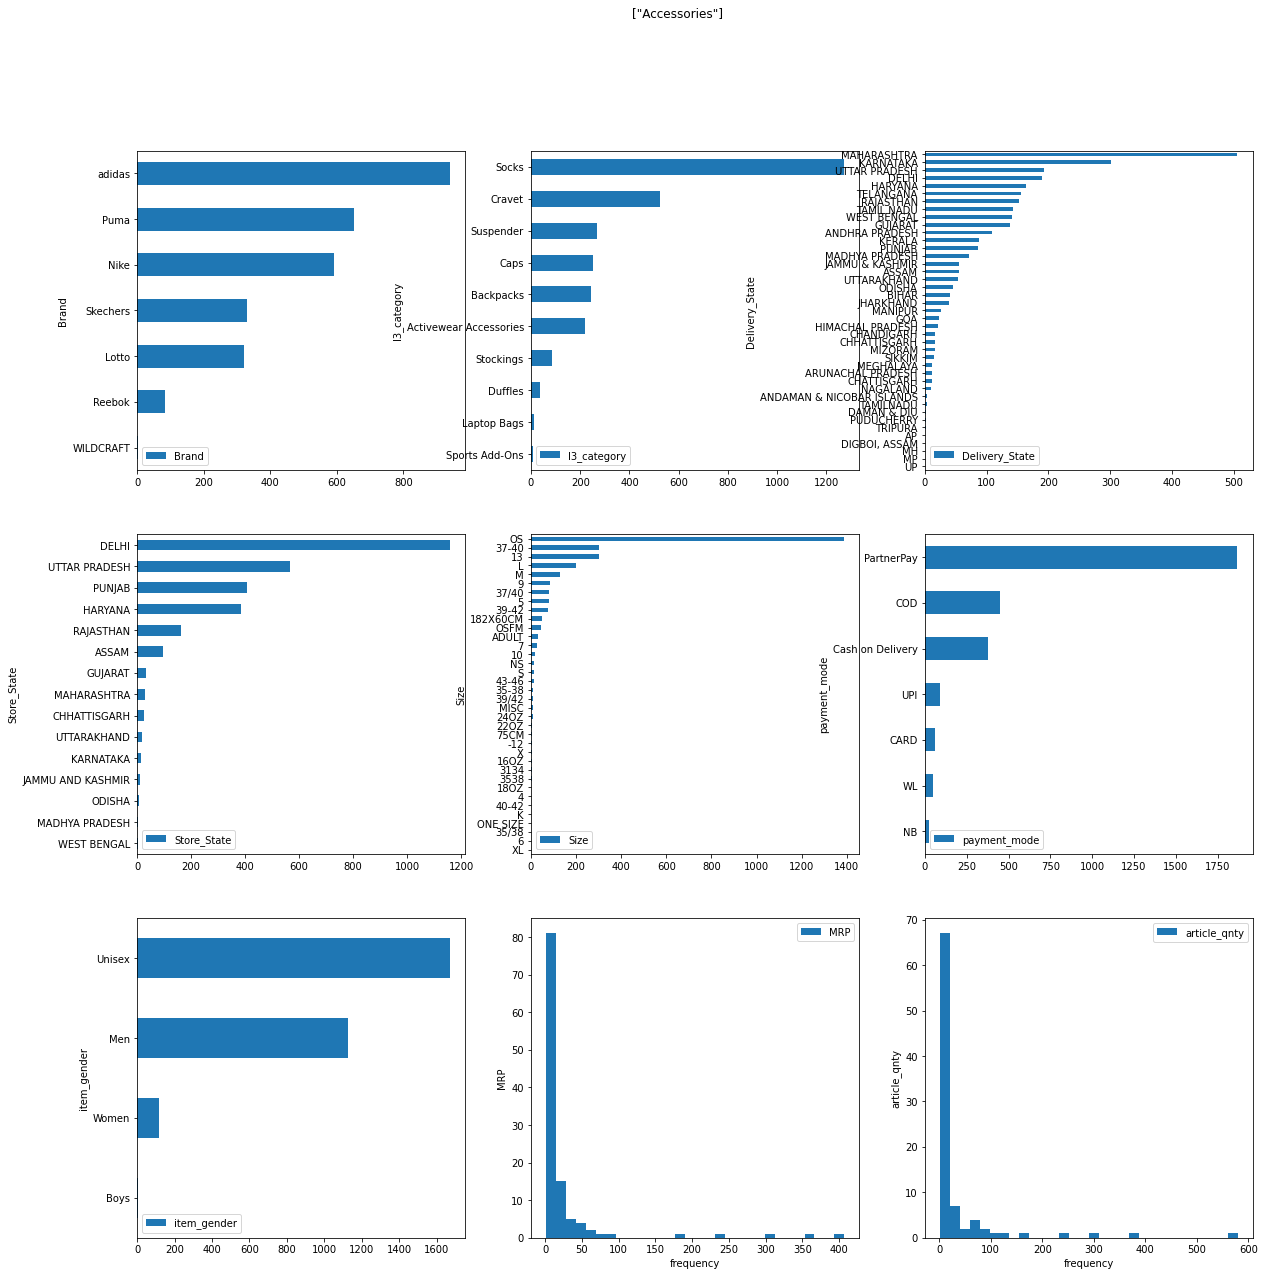

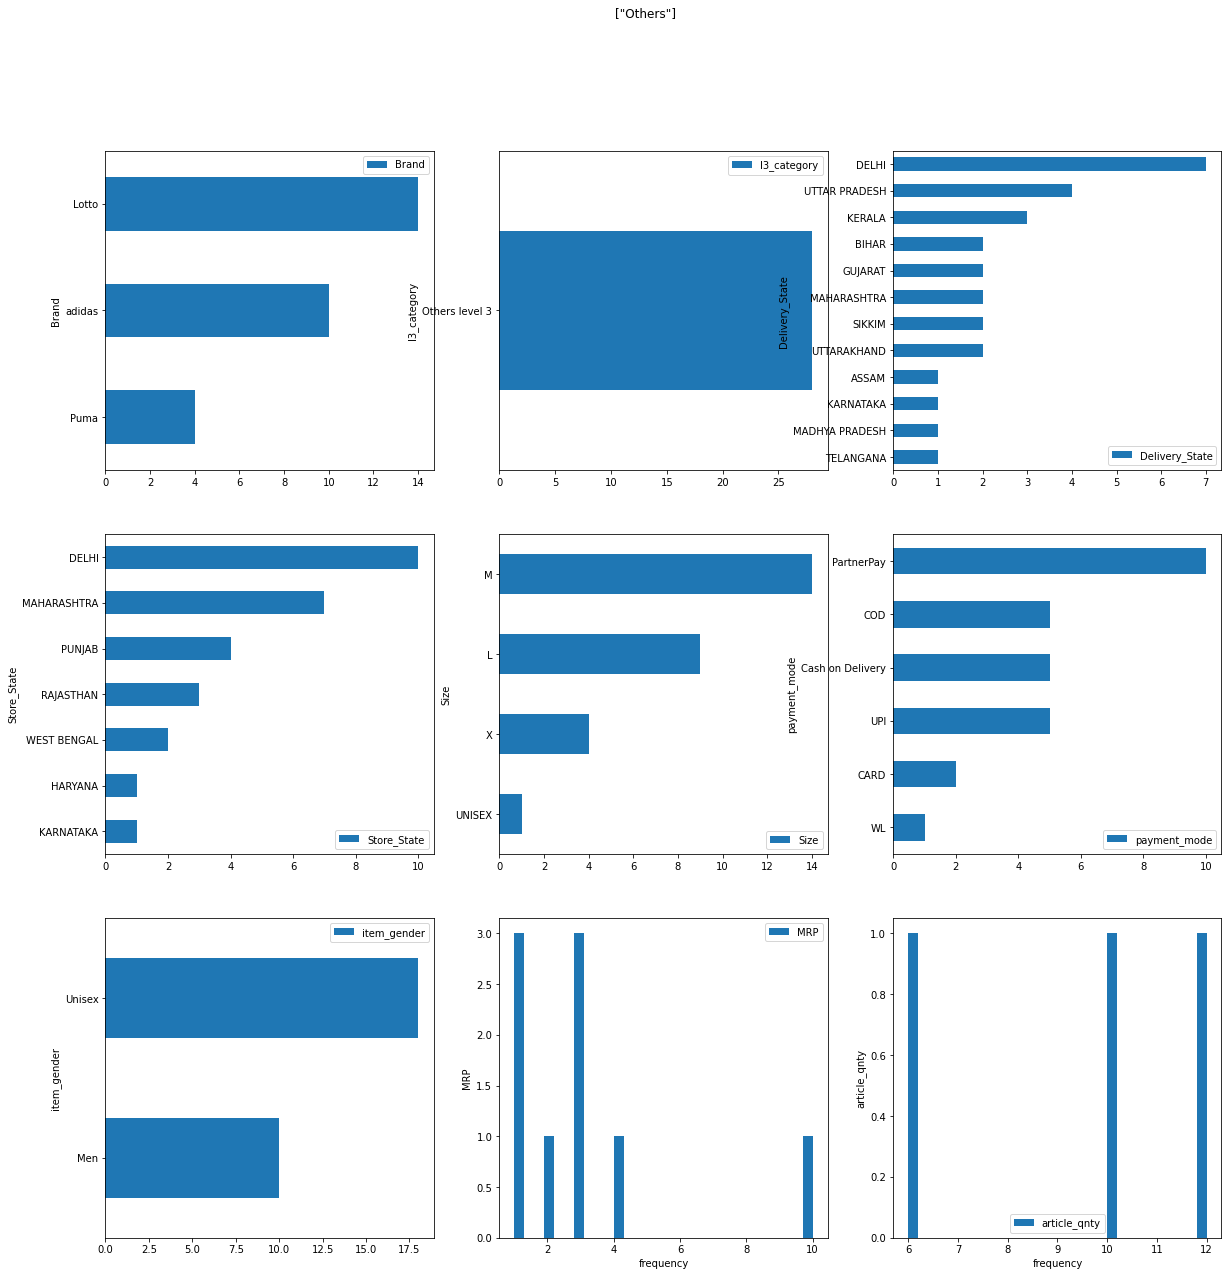

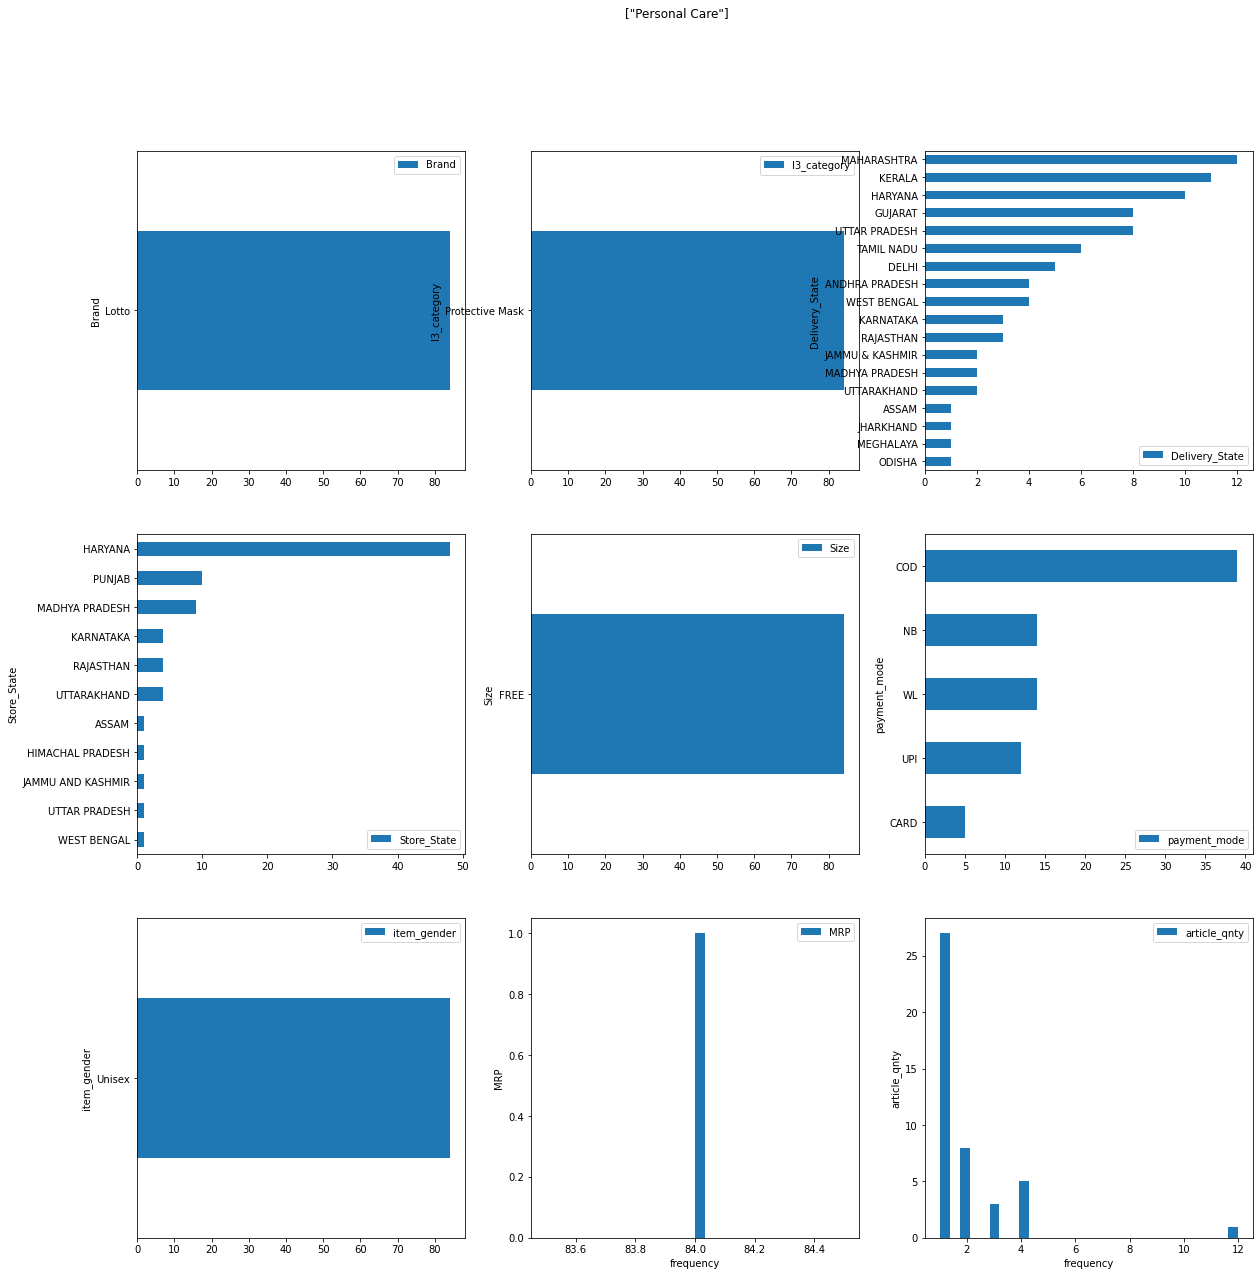

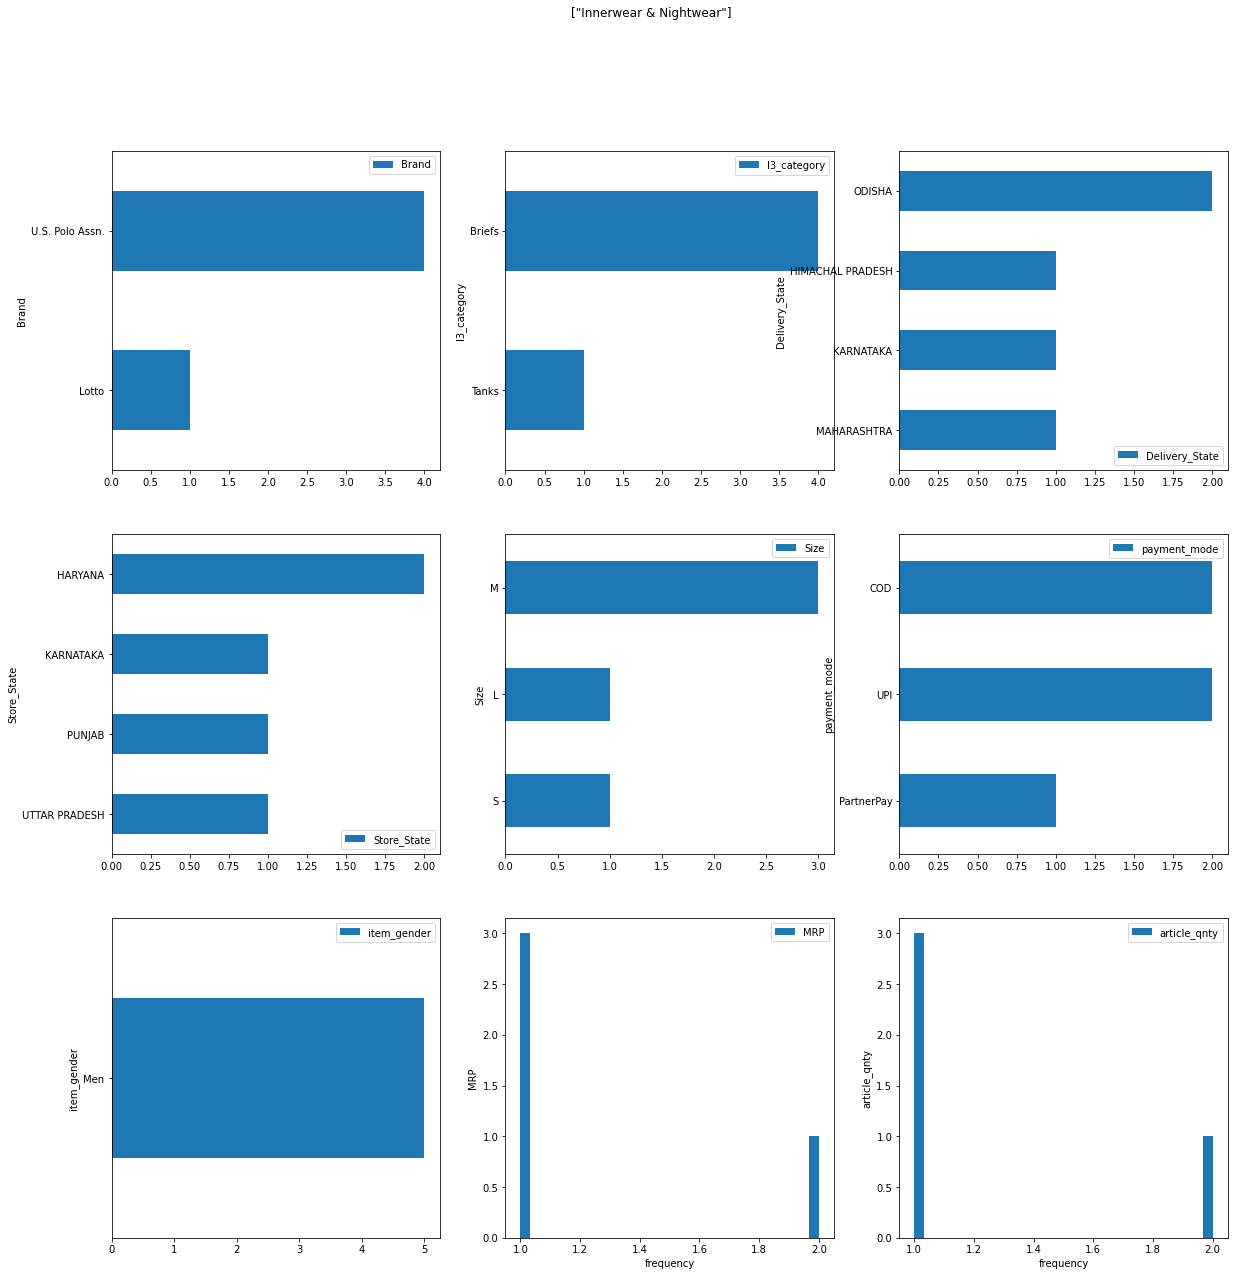

In [34]:
for lev0 in data["l1_category"].unique():
    fig, axes =plt.subplots(3,3, figsize=(20,20))
    for i, var in enumerate(group_by_cat_vars):
        results = data.groupby("l1_category")[var].value_counts().to_frame()
        if var not in num_vars:
            locals()[lev0+var+'_df'] = pd.DataFrame(results.loc[lev0,:]).plot.barh(ax = axes[i//3,i%3])
            axes[i//3,i%3].invert_yaxis()
        else:
            # locals()[lev0+var+'_df'] = pd.DataFrame(results.loc[lev0,:]).plot.hist(bins= 30, ax = axes[i//3,i%3] )
            sns.boxplot(results.loc[lev0,:],palette="deep")
            axes[i//3,i%3].set_ylabel(var)
            axes[i//3,i%3].set_xlabel("frequency")
    plt.suptitle(lev0)
    plt.show()